# Vecinos más Cercanos [ Nearest Neighbor  ]

Méndez Pool Joan de Jesús | 160300102

In [1]:
library(dplyr)
# Plots
library(ggplot2)
library(psych)
# Clasificación knn
library(class)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



<p style="text-align:justify">El método de vecinos más cercanos funciona para clasificar casos basándose con el parecido a otros casos. Los casos parecidos están próximos y los que no lo son están alejados entre sí, esto hace que entre dos casos es una medida de disimilidad. <br><br> Los casos más próximos entre sí se denomidan "vecinos". Cuando se presenta un nuevo caso, se calcula su distancia con respecto a los casos del modelo. LAs clasificaciones de los casos más parecidos se cuadran y el nuevo caso se incluye en la categoría que contiene el mayor número de vecinos próximos.</p>

In [2]:
# 1.- Cargamos los datos a trabajar y observamos cuales son nuestros predictores
df <- read.csv("Prostate_Cancer.csv")
head(df)

id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
1,M,23,12,151,954,0.143,0.278,0.242,0.079
2,B,9,13,133,1326,0.143,0.079,0.181,0.057
3,M,21,27,130,1203,0.125,0.160,0.207,0.060
4,M,14,16,78,386,0.070,0.284,0.260,0.097
5,M,9,19,135,1297,0.141,0.133,0.181,0.059
6,B,25,25,83,477,0.128,0.170,0.209,0.076


<p style="text-align:justify"> Lo primero a realizar es obtener información de los predictores calculando su media, promedio, el valor máximo y mínimo para cada variable predictora, de esta forma podemos tener una noción de como se comportan las variables.</p>

In [3]:
# 2.- Resumen de los datos
summary(df)

       id         diagnosis_result     radius         texture     
 Min.   :  1.00   B:38             Min.   : 9.00   Min.   :11.00  
 1st Qu.: 25.75   M:62             1st Qu.:12.00   1st Qu.:14.00  
 Median : 50.50                    Median :17.00   Median :17.50  
 Mean   : 50.50                    Mean   :16.85   Mean   :18.23  
 3rd Qu.: 75.25                    3rd Qu.:21.00   3rd Qu.:22.25  
 Max.   :100.00                    Max.   :25.00   Max.   :27.00  
   perimeter           area          smoothness      compactness    
 Min.   : 52.00   Min.   : 202.0   Min.   :0.0700   Min.   :0.0380  
 1st Qu.: 82.50   1st Qu.: 476.8   1st Qu.:0.0935   1st Qu.:0.0805  
 Median : 94.00   Median : 644.0   Median :0.1020   Median :0.1185  
 Mean   : 96.78   Mean   : 702.9   Mean   :0.1027   Mean   :0.1267  
 3rd Qu.:114.25   3rd Qu.: 917.0   3rd Qu.:0.1120   3rd Qu.:0.1570  
 Max.   :172.00   Max.   :1878.0   Max.   :0.1430   Max.   :0.3450  
    symmetry      fractal_dimension
 Min.   :0.1

<p style="text-align:justify"> Con la gráfica de pares podemos visualizar la dispensión de los datos coloreado por etiquetas, el histograma de frecuencia que nos muestra la distribución de la variable predictora, y la correlación que posee con las otras variables. Las variables predictoras aparentan tener una distribución normal en su mayoría.</p>

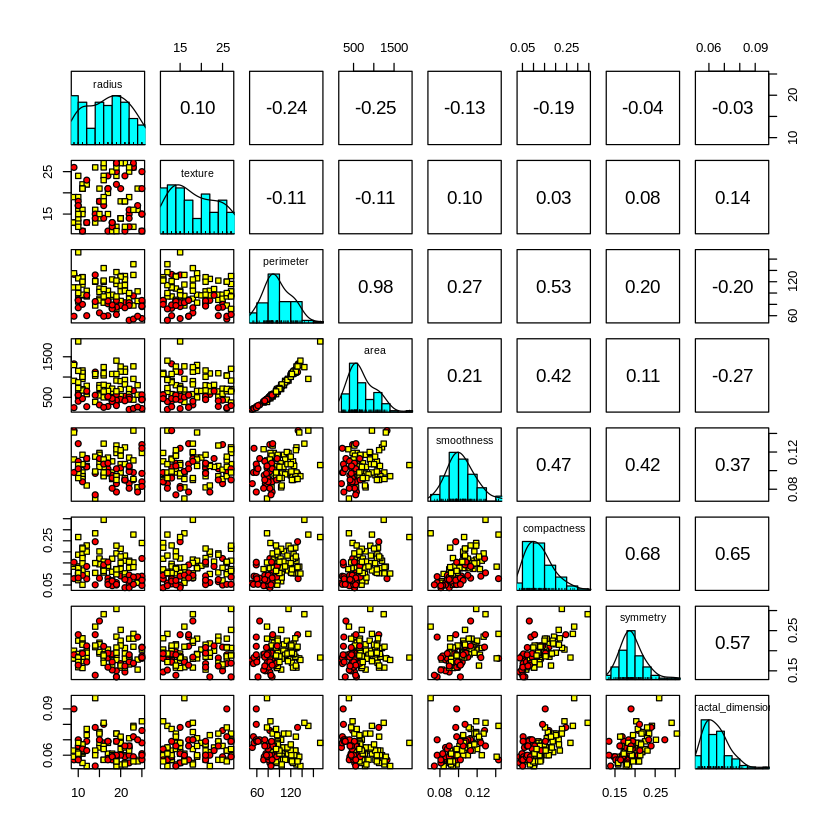

In [4]:
p <- df %>% select(-id, -diagnosis_result)
pairs.panels(p, bg=c("red", "yellow", "green")[df$diagnosis_result], 
             pch=20+as.numeric(df$diagnosis_result), smooth=FALSE, ellipses=FALSE)

<p style="text-align:justify">  Para aplicar correctamente el método de vecinos más cercanos debemos <strong>estandarizar</strong> las variables dado que pueden estar definidas en escalas muy dispares. 

Estandarizar una variable se realiza restando la media y dividiendo entre la desviación estándar:

$$x_h = \frac{x-\overline{x}}{\sigma_x}$$

El objetivo de estandarizar una variable es que ahora tenga una media de cero y una desviación estándar de 1. </p>

In [5]:
# 3.- Estandarizar los Datos

labels <- df$diagnosis_result
id_df <- df$id

diag <- df %>% select(-id, -diagnosis_result)
diag <- data.frame(scale(diag))

diag$id <- id_df
diag$diagnosis_result <- labels
summary(diag)

     radius            texture          perimeter            area        
 Min.   :-1.60891   Min.   :-1.3923   Min.   :-1.8914   Min.   :-1.5667  
 1st Qu.:-0.99404   1st Qu.:-0.8146   1st Qu.:-0.6031   1st Qu.:-0.7073  
 Median : 0.03074   Median :-0.1406   Median :-0.1174   Median :-0.1842  
 Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.85057   3rd Qu.: 0.7741   3rd Qu.: 0.7379   3rd Qu.: 0.6697  
 Max.   : 1.67039   Max.   : 1.6888   Max.   : 3.1770   Max.   : 3.6756  
   smoothness        compactness         symmetry       fractal_dimension
 Min.   :-2.23539   Min.   :-1.4507   Min.   :-1.8896   Min.   :-1.4342  
 1st Qu.:-0.63039   1st Qu.:-0.7556   1st Qu.:-0.6877   1st Qu.:-0.6981  
 Median :-0.04986   Median :-0.1341   Median :-0.1030   Median :-0.2073  
 Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.63312   3rd Qu.: 0.4956   3rd Qu.: 0.5142   3rd Qu.: 0.5288  
 Max.   : 2.75035   Max.   : 3.5703   

<p style="text-align:justify">Ahora graficamos las variables predictoras para observar si tuvo un cambio con respecto a la gráfica de pares anterior, podemos apreciar que su correlación no cambia absolutamente nada, los histogramas de frecuencias se asemejan más a una distribución normal, y en los diagramas de dispersión no se notan muchos cambios en la dispersión de los puntos.</p>

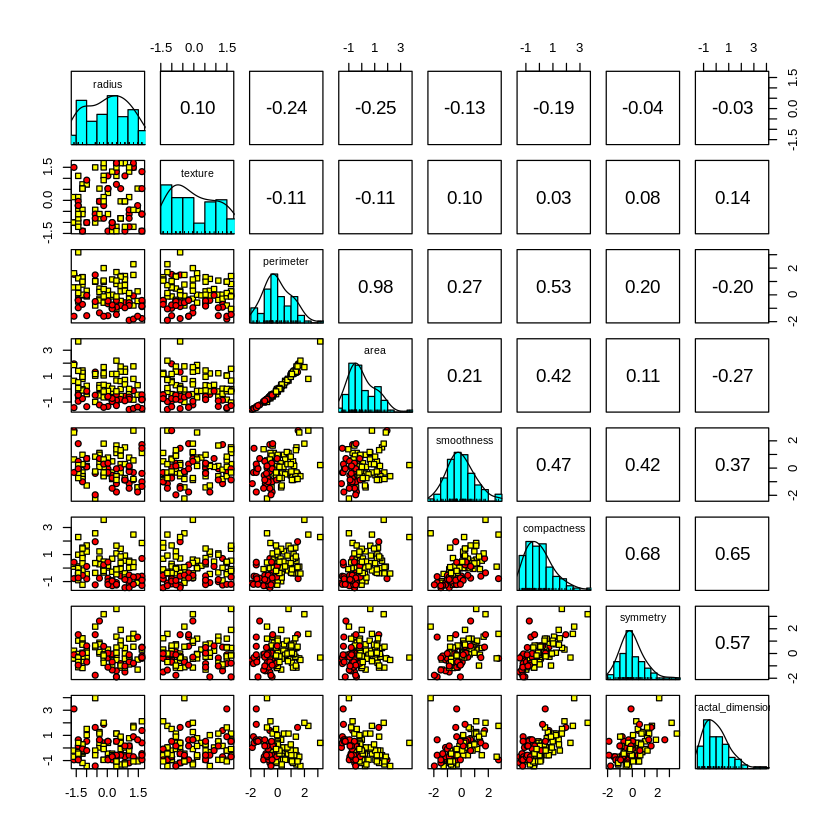

In [6]:
d <- diag %>% select(-id, -diagnosis_result)
pairs.panels(d, bg=c("red", "yellow", "green")[df$diagnosis_result], 
             pch=20+as.numeric(df$diagnosis_result), smooth=FALSE, ellipses=FALSE)

# Estandarizar Variables Predictoras

<p style="text-align:justify">Separamos el conjunto de entrenamiento y el conjunto de pruebas para construir nuestro modelo de predicción.</p>

In [7]:
# 4.- Separar datos de entrenamiento y prueba
n <- length(df$id)
id_test <- sample(1:n, as.integer(0.2 * n)) 

In [8]:
test <- diag[id_test,] # Test
train <- diag[-id_test,]  #Trainer

<p style="text-align:justify"> Necesitamos quitar las etiquetas de nuestros conjuntos porque el comando <i>
knn</i> solo trabaja con variables númericas, debemos hacer un respaldo de la información de las etiquetas de cada conjunto.</p>

In [9]:
# Quitar las etiquetas del df
train_cl=train$diagnosis_result
test_cl=test$diagnosis_result

train <- train %>% select(-diagnosis_result)
test <- test %>% select(-diagnosis_result)

<p style="text-align:justify"> Realizamos la prueba de validación cruzada para obtener un valor de <i>k</i> óptimo de vecinos que minimize los errores de prediccón en el módelo.</p> 

In [10]:
# Validación cruzada
err=c()
for (i in 1:length(train$id)){
    knn_cl <- knn(train,test,train_cl, k=i)
    res <- data.frame(real_class = test_cl, knn_cl, k=i)
    err <- c(err, sum(res$real_class!=res$knn_cl))
}
k = which.min(err)
print(paste("Mejor valor para k:", k))


[1] "Mejor valor para k: 3"


<p style="text-align:justify"> Graficamos los errores para visualizar la información obtenida con la validación cruzada para un <i>k</i> óptimo en el modelo. </p>

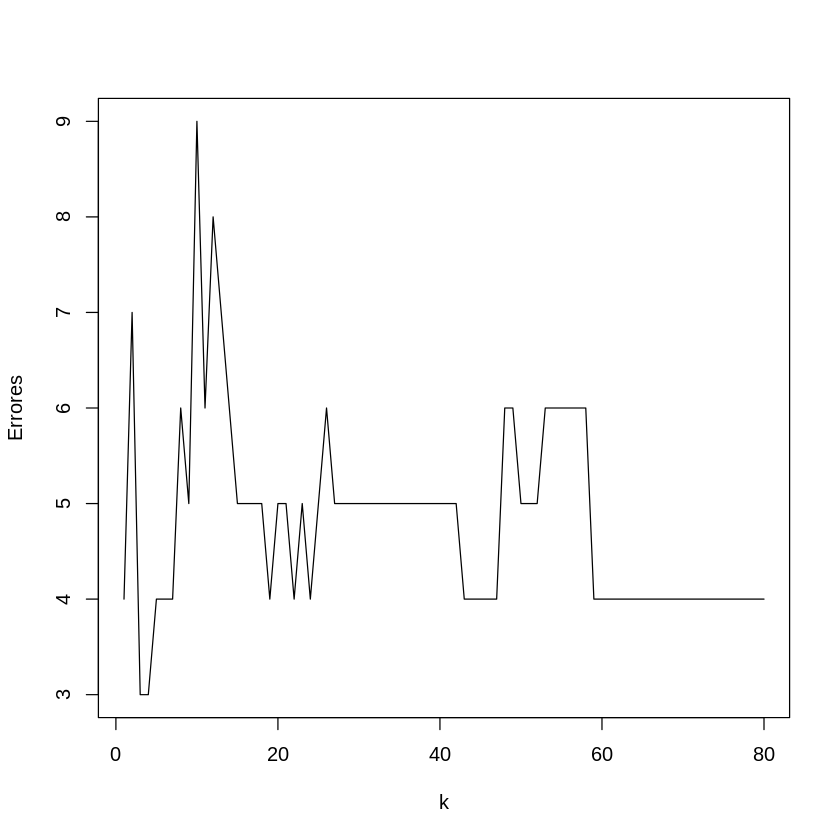

In [11]:
plot(err, xlab="k", ylab="Errores", type="l")

<p style="text-align:justify"> Probamos el modelo con valor de k óptimo y visualizamos el número de errores que tuvo el modelo, al tener un número pequeño de vecinos podemos definir que nuestro modelo estandarizado es flexible porque tenemos una cantidad de pocos vecinos en el modelo.</p>

In [12]:
knn_cl <- knn(train,test,train_cl, k=k)
res <- data.frame(real_class = test_cl, knn_cl, k=k)
terr <- sum(res$real_class!=res$knn_cl)
print(paste("Errores: ", terr))

[1] "Errores:  3"


# Sin estandarizar

<p style="text-align:justify">Realizamos el mismo proceso de separación de nuestros conjuntos de entrenamiento y prueba.</p>

In [13]:
test <- df[id_test,] # Test
train <- df[-id_test,]  #Trainer

# Quitar las etiquetas del df
train_cl=train$diagnosis_result
test_cl=test$diagnosis_result

train <- train %>% select(-diagnosis_result)
test <- test %>% select(-diagnosis_result)

<p style="text-align:justify">Aplicamos validación cruzada para obtener un valor <i>k</i> óptimo de vecinos para nuestro modelo.</p>

In [14]:
err=c()
for (i in 1:length(train$id)){
    knn_cl <- knn(train,test,train_cl, k=i)
    res <- data.frame(real_class = test_cl, knn_cl, k=i)
    err <- c(err, sum(res$real_class!=res$knn_cl))
}
k = which.min(err)
print(paste("Mejor valor para k:", k))

[1] "Mejor valor para k: 49"


<p style="text-align:justify"> Graficamos los errores para visualizar la información obtenida con la validación cruzada para un <i>k</i> óptimo en el modelo. </p>

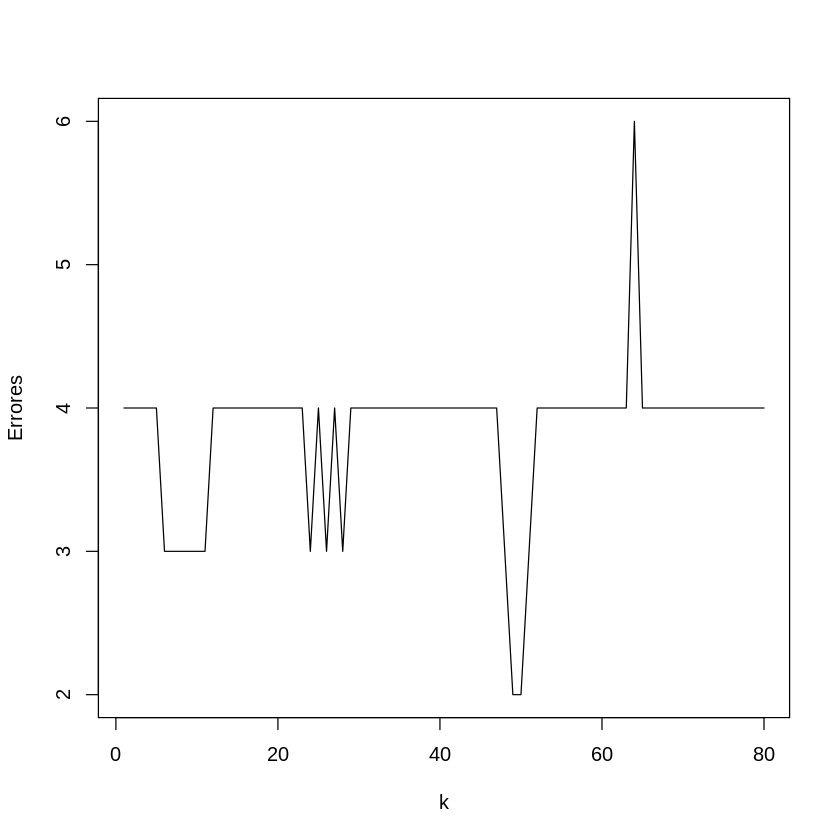

In [15]:
plot(err, xlab="k", ylab="Errores", type="l")

<p style="text-align:justify"> Probamos el modelo con valor de k óptimo y visualizamos el número de errores que tuvo el modelo, al tener un número considerable de vecinos podemos definir que nuestro modelo no estandarizado es rígido ya que posee una cantidad mayor de vecinos en comparación al modelo estandarizado.</p>

In [16]:
knn_cl <- knn(train,test,train_cl, k=k)
res <- data.frame(real_class = test_cl, knn_cl, k=k)
terr <- sum(res$real_class!=res$knn_cl)
print(paste("Errores: ",terr))

[1] "Errores:  2"


# Conclusión
<p style="text-align:justify">En la comparación de los dos casos donde estandarizamos y no estandarizamos las variables predictoras obtenemos una gran diferencia en los resultados, cuando estandarizamos las variables obtenemos un mejor modelo de predicción ya que no queda muy dispersa la información de las variables predictoras, esto es posible porque nos encargamos de que cada variable tenga una media igual a 0 y la desviación estandar igual a 1, obtuvimos un modelo muy flexible en comparación al modelo obtenido al no estandarizar las variables, podemos apreciar que para el caso donde no estandarizamos los predictores obtenemos una menor cantidad de errores, pero obtenemos una mayor cantidad de vecinos que hacen a nuestro modelo de predicción rígido. La aplicación del método de vecinos más cercanos en simple y fácil de implementar en <i>R</i> ya que tenemos un comando que nos permite evaluar el método.</p>